In [51]:
import jax.numpy as jnp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys
import json
import pickle

## Get experiment settings

In [2]:
experiment_settings_filename = 'mixing_exp_settings.json'
with open(experiment_settings_filename, "r") as read_file:
    experiment_settings = json.load(read_file)

In [3]:
print('length: ' + str(len(experiment_settings)))
#experiment_settings[0]
merged_dict = {key: list({frozenset(d[key]) if isinstance(d[key], list) else d[key] for d in experiment_settings if key in d}) for key in {k for d in experiment_settings for k in d.keys()}}
merged_dict = {k:[list(v) if isinstance(v, frozenset) else v for v in values] for k, values in merged_dict.items()}
merged_dict

length: 3


{'n_particles': [15],
 'updates': [10],
 'struct_eq_type': ['linear'],
 'n_observations': [1000],
 'n_queries': [0],
 'expert_reliability': [1],
 'seed': [698],
 'graph_type': ['sf'],
 'steps': [3000],
 'burn_in_steps': [1000],
 'n_runs': [30],
 'n_vars': [20],
 'mixing_rate': [[0.3, 0.7], [0.95, 0.05], [0.5]]}

## Get relevant experiment run indices

In [4]:
# specify allowed parameter in lists
conditions = {'mixing_rate': [[0.5, 0.5], [0.95, 0.05], [0.3, 0.7]],
              'n_queries': [0],
              'n_runs': [30],
              'n_particles': [15],
              'n_vars': [20],
              'n_observations': [1000],
              'graph_type': ['sf'],
              'expert_reliability': [1],
              'struct_eq_type':  ['linear'],
              'steps': [3000],
              'burn_in_steps': [1000],
              'updates': [10]
             }

pickle.dump(conditions,  open('mixing_exp_settings_cond.p', "wb"))

### Compute experiment metrics

In [5]:
metrics_and_indices = pickle.load(open('mixing_exp_settings_metrics.p', "rb"))
# Metrics of shape [experiments, 4, n_runs, component] (four metrics)
metrics, exp_indices = metrics_and_indices[0], metrics_and_indices[1]

# [experiments, n_runs, component]
eshds = [metrics[i][0] for i in range(len(exp_indices))] 
aurocs = [metrics[i][1] for i in range(len(exp_indices))] 
neglls = [metrics[i][2] for i in range(len(exp_indices))] 
ho_neglls = [metrics[i][3] for i in range(len(exp_indices))] 

#### turn results into some elaborate dataframe to easily plot them

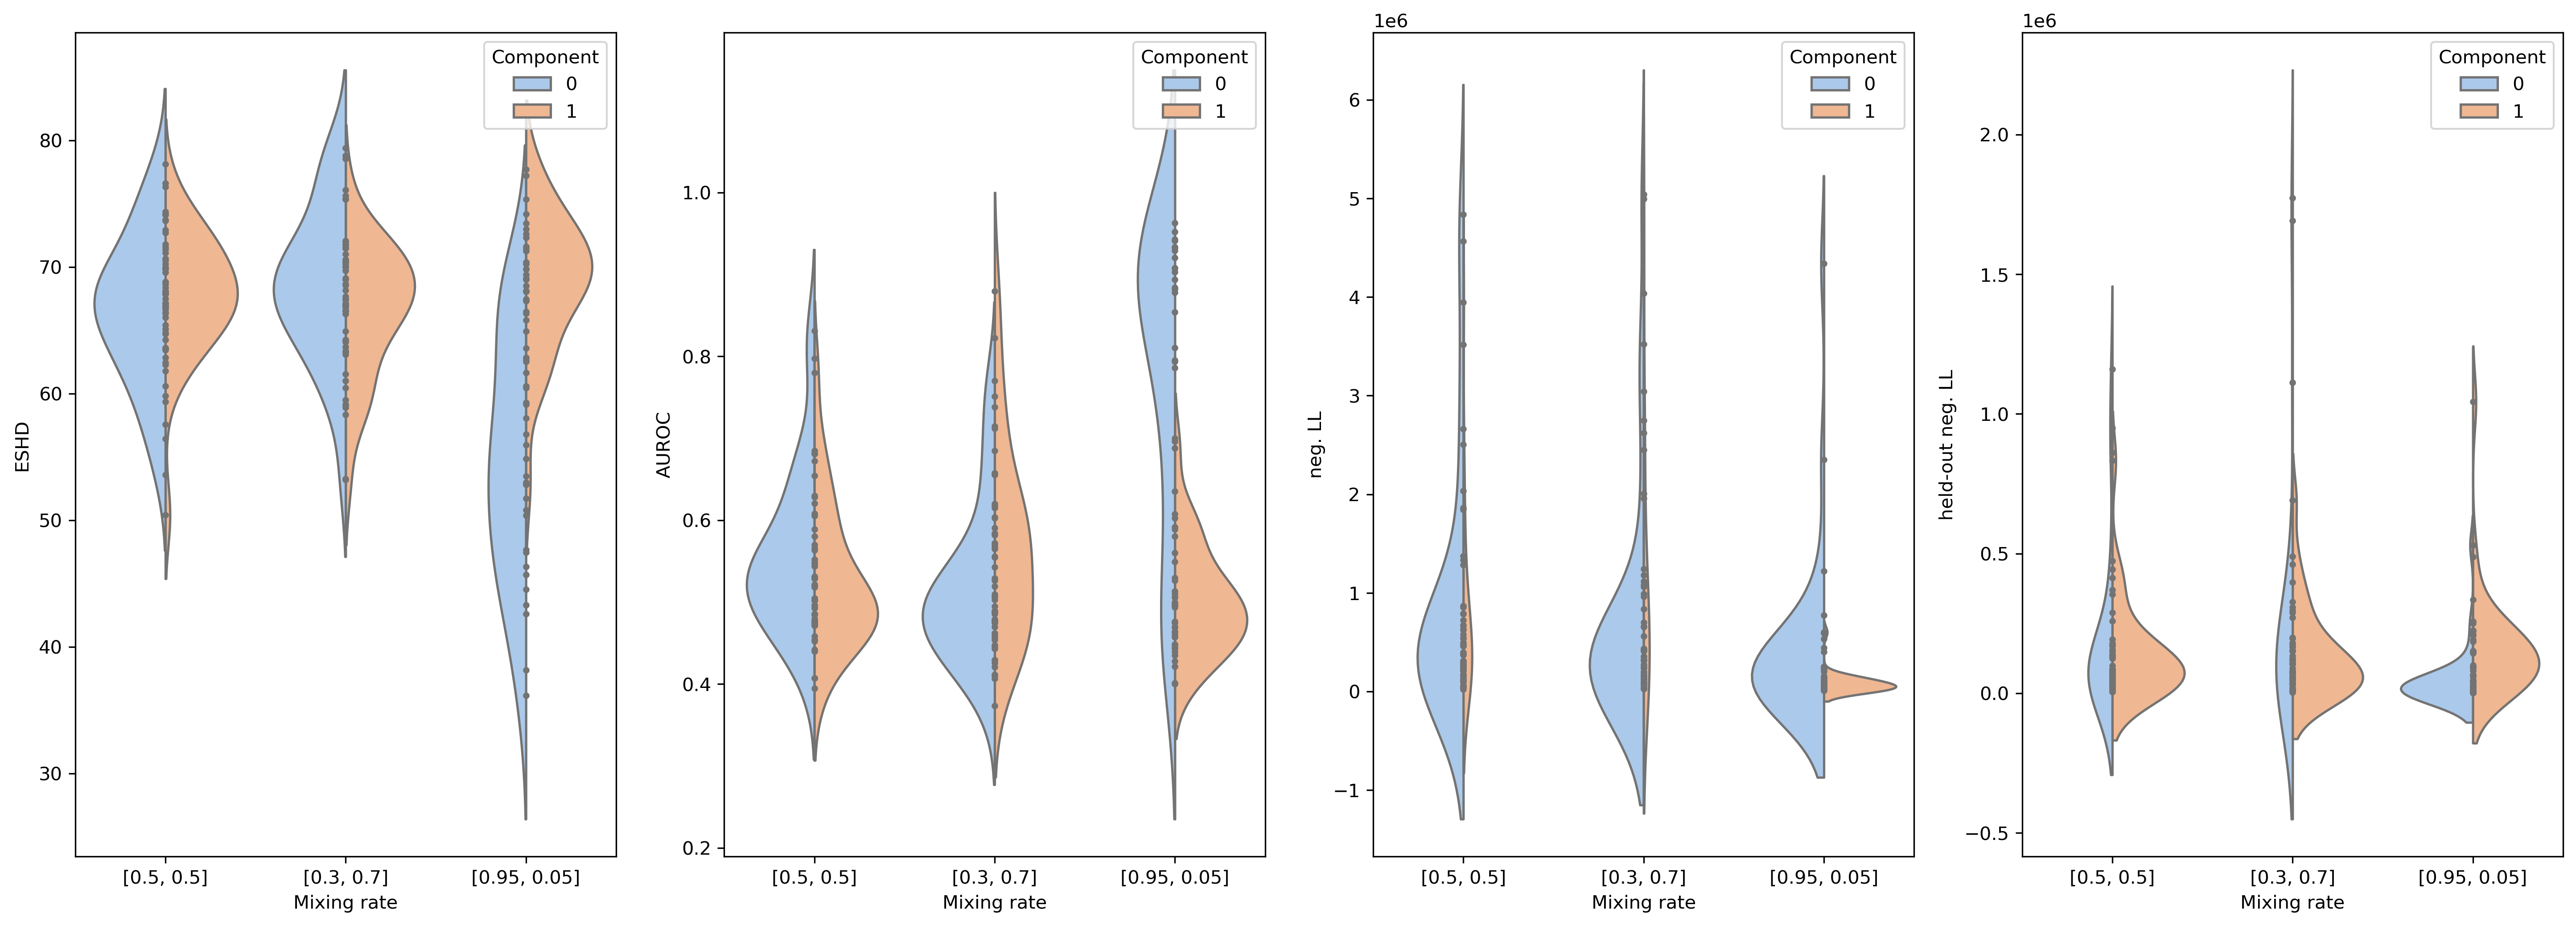

In [74]:
# Choose categorical variable to plot 
category, cat_str = 'mixing_rate', 'Mixing rate'
#category, cat_str = 'graph_type', 'Graph family'
#category, cat_str = 'n_particles', 'Particles per component' 
#category, cat_str = 'expert_reliability', 'Expert reliability'

# plot all metrics component-wise 
fig, axs = plt.subplots(ncols=4, sharey=False, figsize=(24, 8), dpi=300)
for i, plot_metric, plot_metric_str in [(0, eshds, 'ESHD'), (1, aurocs, 'AUROC'), (2, neglls, 'neg. LL'), (3, ho_neglls, 'held-out neg. LL')]:
    #  Create array with metric results experiment- and component-wise (I'm so sorry)
    cat_metrics = [[[(str(experiment_settings[i_experiment][category]), component, metric) for component, metric in enumerate(metric_pair)] for metric_pair in plot_metric[i_metrics]] for i_metrics, i_experiment in enumerate(exp_indices)] 
    flatten = lambda xss: [x for xs in xss for x in xs]
    cat_metrics = flatten(flatten(cat_metrics))
    cat_metrics = np.array(cat_metrics)

    # Convert array to data frame and post process
    df_metrics = pd.DataFrame(cat_metrics, columns=[cat_str, 'Component', plot_metric_str])
    df_metrics[plot_metric_str] = df_metrics[plot_metric_str].apply(lambda x : float(x))
    df = df_metrics.round({plot_metric_str: 2})
    
    # plot metric
    sns.violinplot(data=df_metrics, x=cat_str, y=plot_metric_str, ax=axs[i],
                   split=True, hue="Component", inner="point", palette="pastel")
    
_=plt.show